In [1]:
%pylab inline 
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras.layers import Dropout

Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's set a seed value, so that we can control our models randomness

In [2]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [3]:
# Set the directory paths, for safekeeping: 

root_dir = os.path.abspath('')
data_dir = os.path.join(root_dir, "Dataset")

# Check for existence 
os.path.exists(root_dir)
os.path.exists(data_dir)


True

### Data Loading and Preprocessing

In [4]:
train = pd.read_csv(os.path.join(data_dir,'Train', 'train.csv'), engine='python')
test = pd.read_csv(os.path.join(data_dir, 'Test.csv'), engine='python')

sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submissions.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


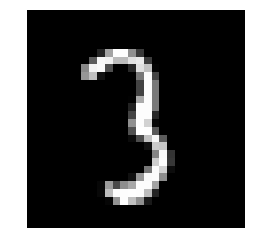

In [5]:
# Read our image and display it
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten = True)

pylab.imshow(img, cmap="gray")
pylab.axis('off')
pylab.show()

In [6]:
# Image as numpy array
img

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

For easier data manipulation, let's store all our images as numpy arrays

In [7]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten = True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

train_x /= 255.0
train_x = train_x.reshape(-1, 784).astype('float32')

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = imread(image_path, flatten = True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

test_x /= 255.0
test_x = train_x.reshape(-1, 784).astype('float32')

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [8]:
train_y = keras.utils.np_utils.to_categorical(train.label.values)

### Train - Test Split:

In [9]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

In [10]:
train.label.ix[split_size:]

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


34300    3
34301    1
34302    6
34303    8
34304    3
34305    8
34306    8
34307    9
34308    3
34309    8
34310    4
34311    6
34312    6
34313    3
34314    6
34315    7
34316    5
34317    3
34318    0
34319    3
34320    9
34321    3
34322    8
34323    8
34324    7
34325    4
34326    3
34327    8
34328    6
34329    5
        ..
48970    7
48971    5
48972    0
48973    1
48974    4
48975    1
48976    7
48977    5
48978    6
48979    5
48980    6
48981    3
48982    5
48983    5
48984    9
48985    2
48986    9
48987    0
48988    0
48989    7
48990    0
48991    1
48992    1
48993    6
48994    9
48995    2
48996    4
48997    9
48998    3
48999    0
Name: label, Length: 14700, dtype: int64

In [11]:
val_x.shape

(14700, 784)

In [12]:
val_y.shape

(14700, 10)

### Model Building

Define a neural netwrok with 3 layers input, hidden and output. 
As the input is our 28x28 image it's size is fix and so is outout layer with 10x1 vector representing the class. 
For hidden layer, we'll use [Adam](https://www.quora.com/Can-you-explain-basic-intuition-behind-ADAM-a-method-for-stochastic-optimization) optimisation algorithm. 

In [13]:
# define vars
input_num_units = 784
hidden_num_units = 50
output_num_units = 10

epochs = 5
batch_size = 128
 
from keras.models import Sequential
from keras.layers import Dense

# Create Model
model = Sequential([
    Dense(output_dim = hidden_num_units, input_dim = input_num_units, activation='relu'),
    Dense(output_dim = output_num_units, input_dim = hidden_num_units, activation='softmax'),
])

# Compile the model with necessary attributes
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=50, activation="relu", input_dim=784)`
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10, activation="softmax", input_dim=50)`
  from ipykernel import kernelapp as app


In [14]:
trained_model = model.fit(train_x, train_y, nb_epoch=epochs, batch_size=batch_size, validation_data=(val_x, val_y))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 34300 samples, validate on 14700 samples
Epoch 1/5
34300/34300 [==============================] - 2s 68us/step - loss: 0.5783 - acc: 0.8441 - val_loss: 0.3300 - val_acc: 0.9090
Epoch 2/5
34300/34300 [==============================] - 1s 43us/step - loss: 0.2768 - acc: 0.9220 - val_loss: 0.2643 - val_acc: 0.9259
Epoch 3/5
34300/34300 [==============================] - 2s 47us/step - loss: 0.2243 - acc: 0.9372 - val_loss: 0.2271 - val_acc: 0.9365
Epoch 4/5
34300/34300 [==============================] - 1s 37us/step - loss: 0.1900 - acc: 0.9468 - val_loss: 0.2059 - val_acc: 0.9439
Epoch 5/5
34300/34300 [==============================] - 2s 48us/step - loss: 0.1654 - acc: 0.9537 - val_loss: 0.1897 - val_acc: 0.9473


### Model Evaluation

Let's visualise our predictions

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Prediction is:  8


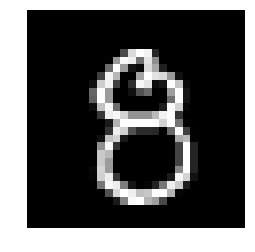

In [27]:
pred = model.predict_classes(test_x)

img_name = rng.choice(test.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - train.shape[0]

print "Prediction is: ", pred[test_index]

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

### Hyperparameter tuning

Some of the ways to optimize a neural network are listed below: 

1. Types of Architecture
2. Number of Layers
3. Number of Neurons in a Layer
4. Regularisation Parameter
5. Learning Rate
6. Type of Optimisation Technique used
7. Dropout rate
8. Weight sharing 

Here, I've implemented some of these ways for better results. Different approaches tried: 
1. Increasing neurons in hidden layer - `hidden_num_units = 500`
2. Adding five hidden layers. Making it deep instead of wide. 
3. Adding Dropout which is essentially randomly turning off parts of the model so that it doesn't overlearn a concept. 
`dropout_ration = 0.2`
4. Increasing number of epochs 
5. Implementing all of the above approaches together

** Implementing 5th approach **

In [16]:
# define vars
# define vars
input_num_units = 784
hidden1_num_units = 500
hidden2_num_units = 500
hidden3_num_units = 500
hidden4_num_units = 500
hidden5_num_units = 500
output_num_units = 10

epochs = 25
batch_size = 128

model = Sequential([
 Dense(output_dim=hidden1_num_units, input_dim=input_num_units, activation='relu'),
 Dropout(0.2),
 Dense(output_dim=hidden2_num_units, input_dim=hidden1_num_units, activation='relu'),
 Dropout(0.2),
 Dense(output_dim=hidden3_num_units, input_dim=hidden2_num_units, activation='relu'),
 Dropout(0.2),
 Dense(output_dim=hidden4_num_units, input_dim=hidden3_num_units, activation='relu'),
 Dropout(0.2),
 Dense(output_dim=hidden5_num_units, input_dim=hidden4_num_units, activation='relu'),
 Dropout(0.2),

Dense(output_dim=output_num_units, input_dim=hidden5_num_units, activation='softmax'),
 ])

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=500, activation="relu", input_dim=784)`
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=500, activation="relu", input_dim=500)`
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=500, activation="relu", input_dim=500)`
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=500, activation="relu", input_dim=500)`
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=500, activation="relu", input_dim=500)`
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update 

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
trained_model_deep_n_wide = model.fit(train_x, train_y, nb_epoch=epochs, batch_size=batch_size, validation_data = (val_x, val_y))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 34300 samples, validate on 14700 samples
Epoch 1/25
34300/34300 [==============================] - 15s 425us/step - loss: 0.3839 - acc: 0.8800 - val_loss: 0.1577 - val_acc: 0.9528
Epoch 2/25
34300/34300 [==============================] - 17s 492us/step - loss: 0.1608 - acc: 0.9535 - val_loss: 0.1313 - val_acc: 0.9615
Epoch 3/25
34300/34300 [==============================] - 19s 541us/step - loss: 0.1158 - acc: 0.9666 - val_loss: 0.1058 - val_acc: 0.9699
Epoch 4/25
34300/34300 [==============================] - 19s 546us/step - loss: 0.0931 - acc: 0.9731 - val_loss: 0.1116 - val_acc: 0.9689
Epoch 5/25
34300/34300 [==============================] - 24s 702us/step - loss: 0.0833 - acc: 0.9753 - val_loss: 0.1060 - val_acc: 0.9703
Epoch 6/25
34300/34300 [==============================] - 23s 670us/step - loss: 0.0723 - acc: 0.9790 - val_loss: 0.1118 - val_acc: 0.9713
Epoch 7/25
34300/34300 [==============================] - 22s 637us/step - loss: 0.0615 - acc: 0.9816 - val_loss: 0.